# Unsupervised Predictions Alignment: breast cancer screening

In [1]:
import sys

root = "."
sys.path.append(root)
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
from metrics_utils import (
    get_op_threshold,
    get_all_dfs_results,
    get_summary_df_from_preds_df,
)


from upa import align_predictions
from experiment_utils import (
    evaluate_alignement_with_repeated_sampling,
    fit_and_evaluate_alignment_binary_classification,
    get_experiment_result_as_plot_update,
    get_experiment_result_as_plot_several_scanners,
)
from plotting_utils import plot_results_ablation_studies

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option("display.precision", 3)

(Path(root) / "plots").mkdir(exist_ok=True)

## Load data and model predictions from disk

In [2]:
# Load the model predictions
model_subdir = "breast_outputs"
model_dir = Path(root) / model_subdir
all_dfs = get_all_dfs_results(model_dir, datasets_to_fetch=["A", "B", "C", "D"])
aggregated = pd.concat(all_dfs.values(), ignore_index=True)

12884
16608
15616
16460


## Datasets characteristics

In [3]:
for k, df in all_dfs.items():
    print(k.upper())
    print(df.id.unique().size)
    print(df.malignant.value_counts(normalize=True))

A
3221
0    0.974
1    0.026
Name: malignant, dtype: float64
B
4152
False    0.982
True     0.018
Name: malignant, dtype: float64
C
3904
False    0.981
True     0.019
Name: malignant, dtype: float64
D
4115
False    0.982
True     0.018
Name: malignant, dtype: float64


## Basic performance metrics prior to alignement

In [4]:
# Compute threshold on ID
reference_df = all_dfs["A"]
reference_thres = get_op_threshold(reference_df.malignant, reference_df.pred1)[0]

# Get the first metrics
get_summary_df_from_preds_df(all_dfs.values(), reference_thres, bootstrap=False)

,ROCAUC,vendOP,vendSens/Spec,GlobalOP,globalSens/Spec,Global Spec/Sens Diff,Global Youden
['A'],0.893,0.193,0.818/0.817,0.193,0.818/0.817,-0.000,0.635
['B'],0.905,0.427,0.824/0.824,0.193,0.970/0.324,-0.645,0.294
['C'],0.866,0.120,0.785/0.785,0.193,0.712/0.877,0.165,0.589
['D'],0.905,0.118,0.824/0.829,0.193,0.740/0.904,0.164,0.644


## Figure 1, illustration of the problem

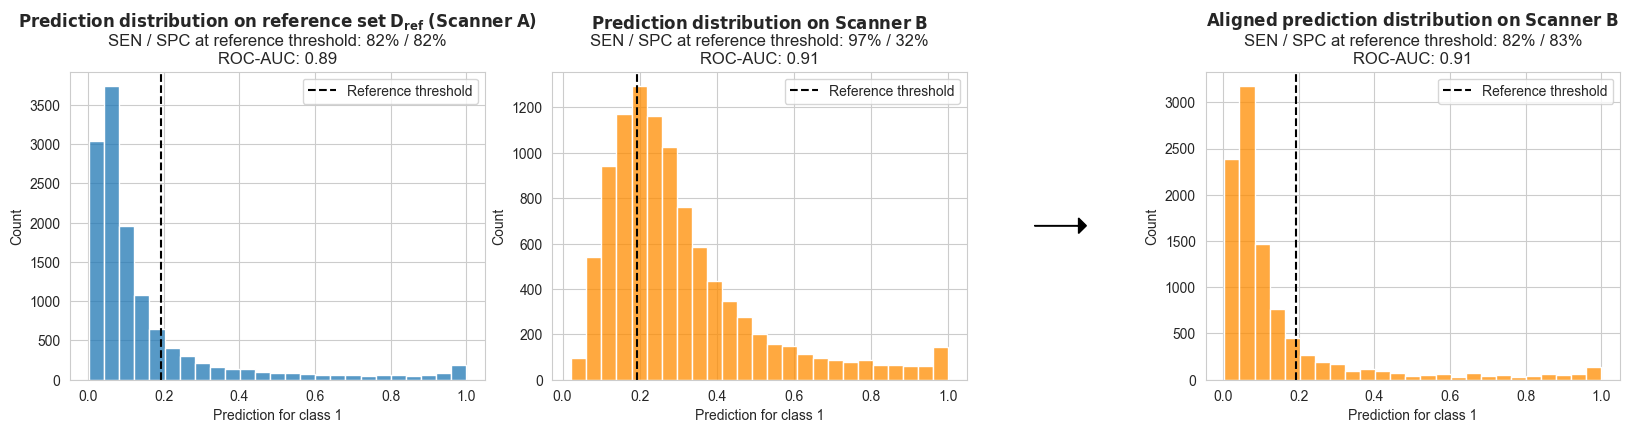

In [5]:
reference_df = all_dfs["A"]
reference_thres, ref_spec, ref_sens = get_op_threshold(
    reference_df.malignant, reference_df.pred1
)
target_recall = (reference_df.pred1 > reference_thres).mean()
ood_df = all_dfs["B"]
patients_for_alignment, patients_for_testing = train_test_split(
    ood_df.id.unique(), train_size=1000, test_size=2500, random_state=2
)
df_for_alignment = ood_df.loc[ood_df.id.isin(patients_for_alignment)]
df_for_testing = ood_df.loc[ood_df.id.isin(patients_for_testing)]
transformed_pred1 = align_predictions(reference_df, df_for_alignment, df_for_testing)[
    :, 1
]


result_df = fit_and_evaluate_alignment_binary_classification(
    reference_df,
    reference_thres,
    df_for_alignment,
    df_for_testing,
)

sns.set_style("whitegrid")
f, ax = plt.subplots(1, 4, figsize=(20, 4), gridspec_kw={"width_ratios": [4, 4, 1, 4]})
sns.histplot(x=reference_df["pred1"], bins=25, ax=ax[0])
ax[0].axvline(x=reference_thres, ls="--", label=f"Reference threshold", color="black")
ax[0].legend()
ax[0].set_title(
    r"$\bf{Prediction}$ $\bf{distribution}$ $\bf{on}$ $\bf{reference}$ $\bf{set}$ $\bf{D_{ref}}$ $\bf{(Scanner}$ $\bf{A)}$"
    + f"\nSEN / SPC at reference threshold: {ref_sens*100:.0f}% / {ref_spec*100:.0f}%"
    + f"\nROC-AUC: {roc_auc_score(reference_df['malignant'].values, reference_df['pred1'].values):.2f}"
)

sns.histplot(x=df_for_testing["pred1"], bins=25, ax=ax[1], color="darkorange")
observed_recall = (df_for_testing["pred1"] > reference_thres).mean()
ax[1].axvline(x=reference_thres, ls="--", label=f"Reference threshold", color="black")
ax[1].legend()
ax[1].set_title(
    r"$\bf{Prediction}$ $\bf{distribution}$ $\bf{on}$ $\bf{Scanner}$ $\bf{B}$"
    + f"\nSEN / SPC at reference threshold: {result_df['sens'][0]*100:.0f}% / {result_df['spec'][0]*100:.0f}%"
    + f"\nROC-AUC: {roc_auc_score(df_for_testing['malignant'].values, df_for_testing['pred1'].values):.2f}"
)

ax[2].arrow(
    0,
    0.5,
    0.5,
    0,
    width=0.001,
    head_width=0.05,
    length_includes_head=True,
    color="black",
)
ax[2].set_xlim([0, 1])
ax[2].set_ylim([0, 1])
ax[2].set_yticks([])
ax[2].set_ylabel("")
ax[2].set_axis_off()

sns.histplot(x=transformed_pred1, bins=25, ax=ax[3], color="darkorange")
ax[3].axvline(x=reference_thres, ls="--", label=f"Reference threshold", color="black")
ax[3].legend()
ax[3].set_title(
    r"$\bf{Aligned}$ $\bf{prediction}$ $\bf{distribution}$ $\bf{on}$ $\bf{Scanner}$ $\bf{B}$"
    + f"\nSEN / SPC at reference threshold: {result_df['sens'][1]*100:.0f}% / {result_df['spec'][1]*100:.0f}%"
    + f"\nROC-AUC: {roc_auc_score(df_for_testing['malignant'].values, transformed_pred1):.2f}"
)
[ax[i].set_xlabel("Prediction for class 1") for i in [0, 1, 3]]
plt.savefig("plots/figure1.pdf", bbox_inches="tight")
plt.savefig("plots/figure1.jpg", bbox_inches="tight", dpi=600)
plt.show()

## Scenario 1: Alignment on OOD dataset with model calibrated on ID only.

In [6]:
n_repeat = 500

# default operating point choice for this study
operating_point = "diag"

reference_df = all_dfs["A"]
reference_thres = get_op_threshold(
    reference_df.malignant, reference_df.pred1, operating_point
)[0]
datasets_to_evaluate = ["B", "D", "C"]
plt.rcParams.update({"font.size": 12})

B


roc_auc          sens          spec         \
               mean    std   mean    std   mean    std   
Predictions                                              
Aligned       0.905  0.011  0.832  0.021  0.811  0.010   
Original      0.905  0.011  0.970  0.010  0.324  0.004   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                  0.021  0.025  0.644  0.021  
Original                                 0.645  0.011  0.294  0.010

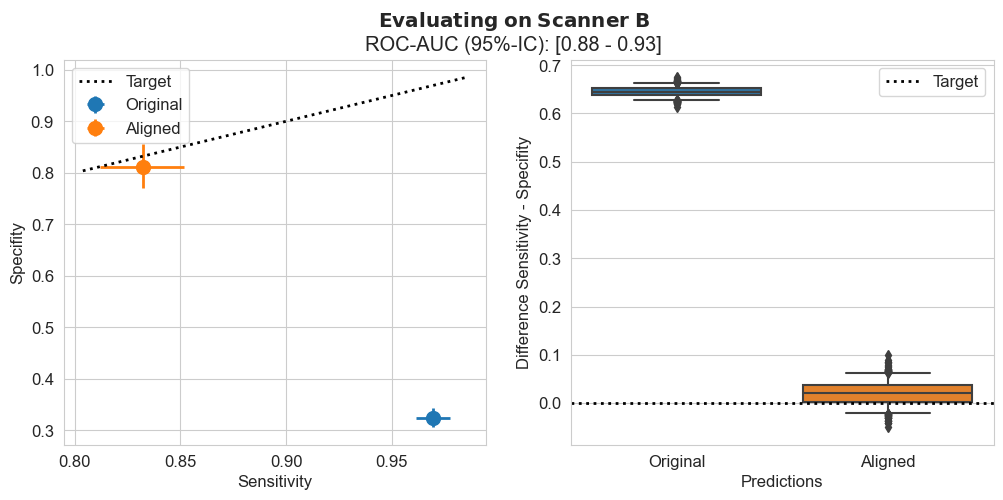

D


roc_auc          sens          spec         \
               mean    std   mean    std   mean    std   
Predictions                                              
Aligned       0.904  0.009  0.827  0.020  0.811  0.010   
Original      0.904  0.009  0.740  0.023  0.904  0.002   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                  0.016  0.024  0.638  0.020  
Original                                -0.164  0.024  0.644  0.023

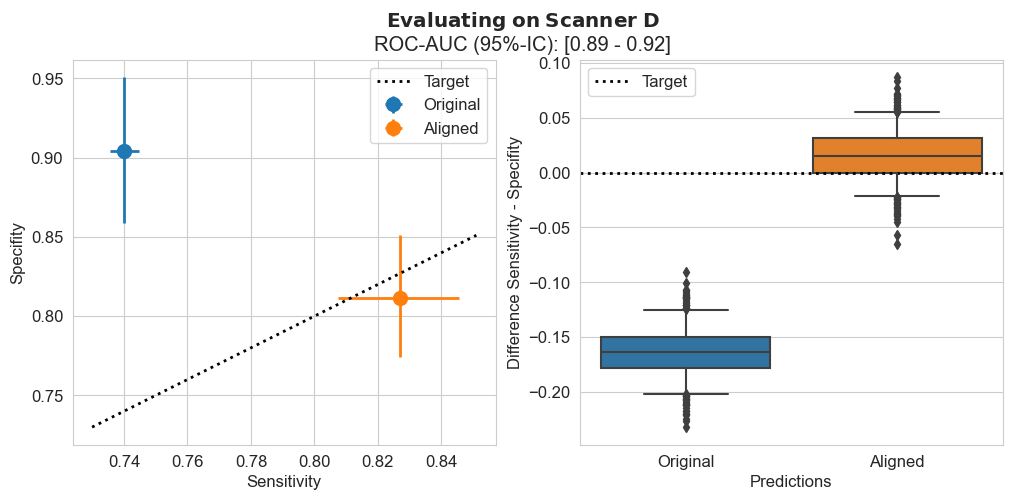

C


roc_auc         sens          spec         \
               mean   std   mean    std   mean    std   
Predictions                                             
Aligned       0.867  0.01  0.774  0.020  0.812  0.010   
Original      0.867  0.01  0.713  0.022  0.877  0.003   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                 -0.038  0.025  0.586  0.019  
Original                                -0.164  0.022  0.590  0.022

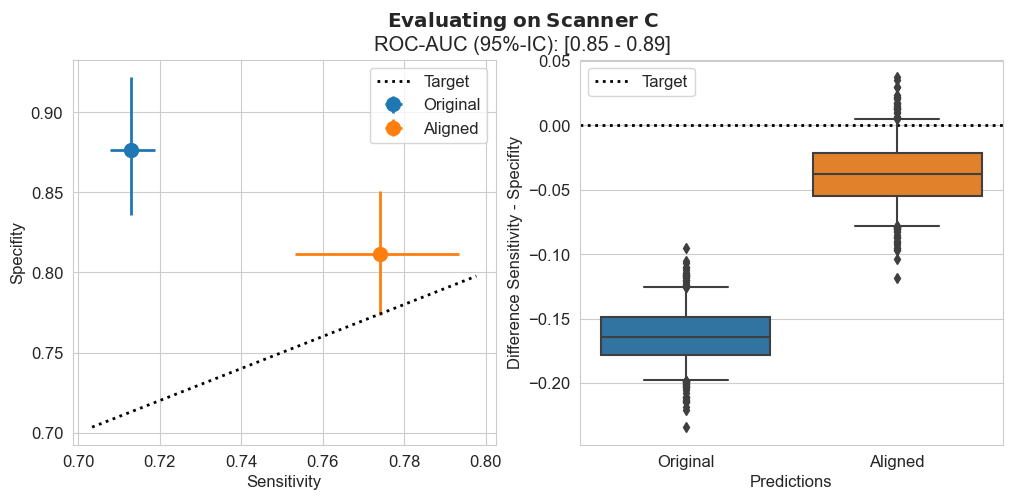

In [7]:
for dataset in datasets_to_evaluate:
    df = all_dfs[dataset]
    results = evaluate_alignement_with_repeated_sampling(
        df, reference_df, reference_thres, n_repeat
    )
    print(dataset.upper())
    display(
        results.groupby("Predictions")[
            ["roc_auc", "sens", "spec", "Difference Sensitivity - Specifity", "youden"]
        ].aggregate(["mean", "std"])
    )
    plot_results_ablation_studies(
        results, "Predictions", dataset, operating_point=operating_point
    )

### Scenario 2: Progressive site decommissioning
A new scanner is installed, and the old scanner will be decommissioned. There is a planned transition period where the old and new scanner are used in parallel with a gradual switch to the new scanner. At the start, there is only data from scanner A, at the end there is only data from scanner B. Initial thresholds were optimised for scanner A.

100%|██████████| 250/250 [07:14<00:00,  1.74s/it]


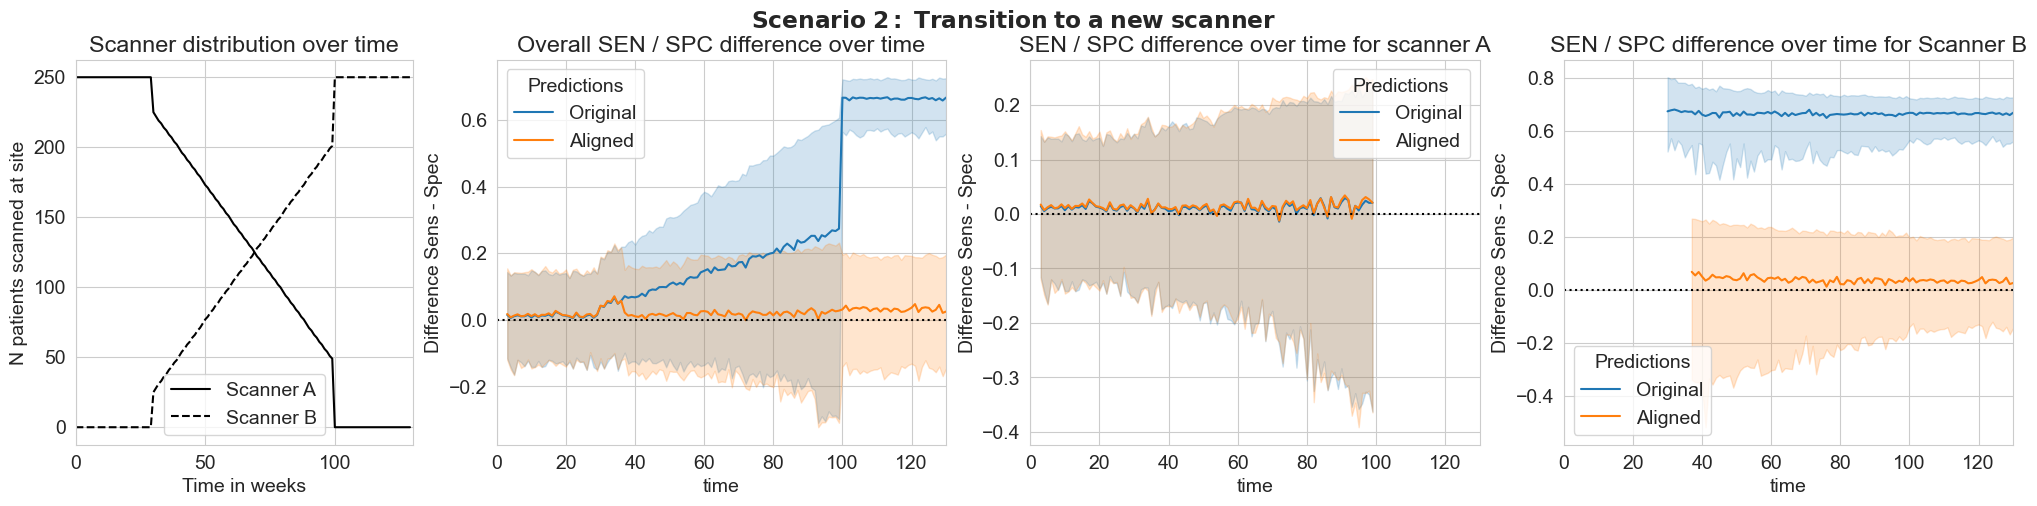

In [8]:
plt.rcParams.update({"font.size": 14})
sns.set_style("whitegrid")

patients_ref, patients_for_simulation = train_test_split(
    all_dfs["A"].id.unique(), train_size=1200, random_state=11
)

reference_df = all_dfs["A"].loc[all_dfs["A"].id.isin(patients_ref)]
reference_threshold = get_op_threshold(reference_df.malignant, reference_df.pred1)[0]
scanner_1_df = all_dfs["A"].loc[all_dfs["A"].id.isin(patients_for_simulation)]
scanner_2_df = all_dfs["B"]
roc_auc_score(scanner_1_df.malignant, scanner_1_df.pred1), roc_auc_score(
    scanner_2_df.malignant, scanner_2_df.pred1
), roc_auc_score(
    np.concatenate([scanner_2_df.malignant.values, scanner_1_df.malignant.values]),
    np.concatenate([scanner_2_df.pred1.values, scanner_1_df.pred1.values]),
)

get_experiment_result_as_plot_several_scanners(
    "A", scanner_1_df, scanner_2_df, reference_df, reference_threshold, n_repeat=250
)

### Scenario 3: new scanner addition

A new scanner is installed, and the old scanner will continue to be used in parallel. The new scanner is introduced gradually, meaning the total number of scans is slowly increasing over time with the proportion of old vs new reaching 50/50 eventually, and the number of cases doubling.  Initial thresholds were optimised for scanner A.

100%|██████████| 250/250 [08:16<00:00,  1.99s/it]


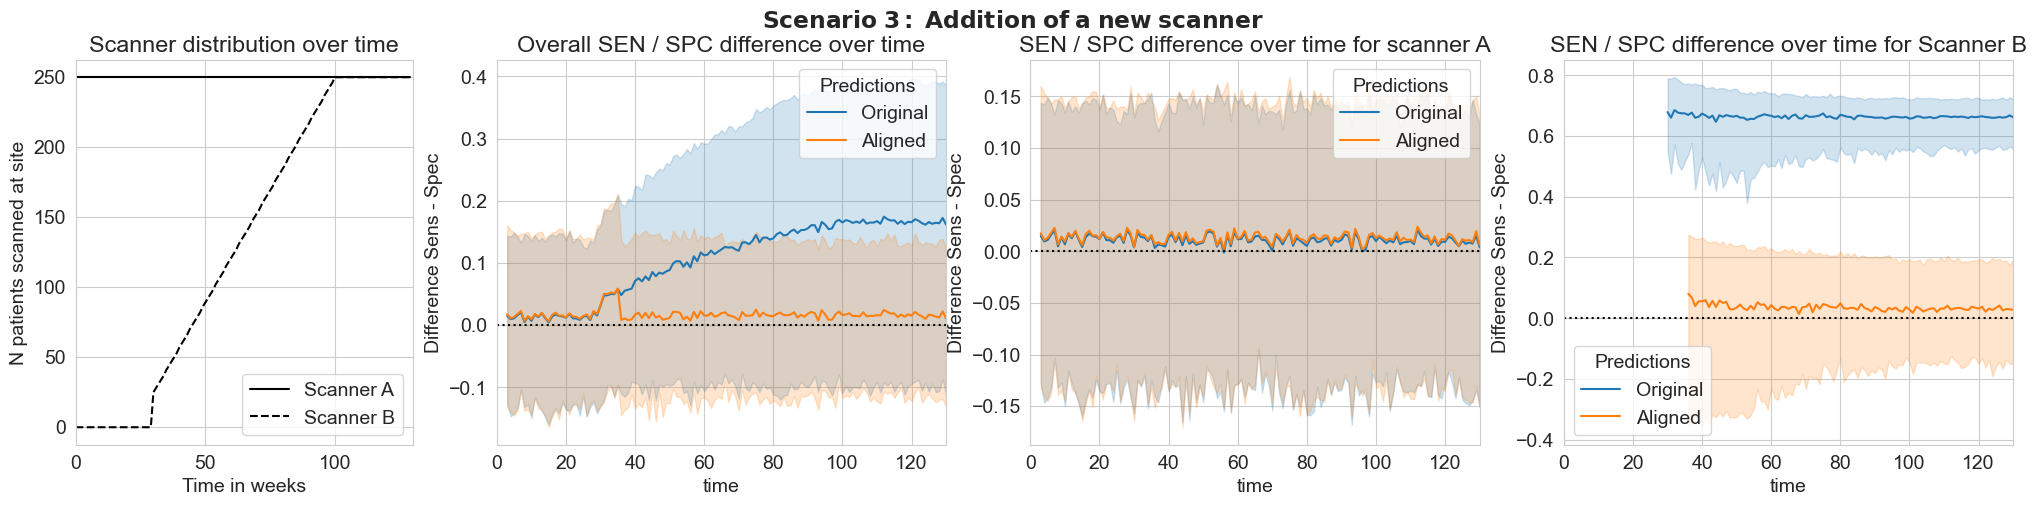

In [9]:
get_experiment_result_as_plot_several_scanners(
    "B", scanner_1_df, scanner_2_df, reference_df, reference_threshold, n_repeat=250
)

### Scenario 4: Software update
The site has a single scanner, at deployment time TO thresholds are optimized for this scanner. At T1 = 50 days, an image processing software update is deployed to this scanner inducing an increase in image sharpness.

100%|██████████| 250/250 [06:04<00:00,  1.46s/it]


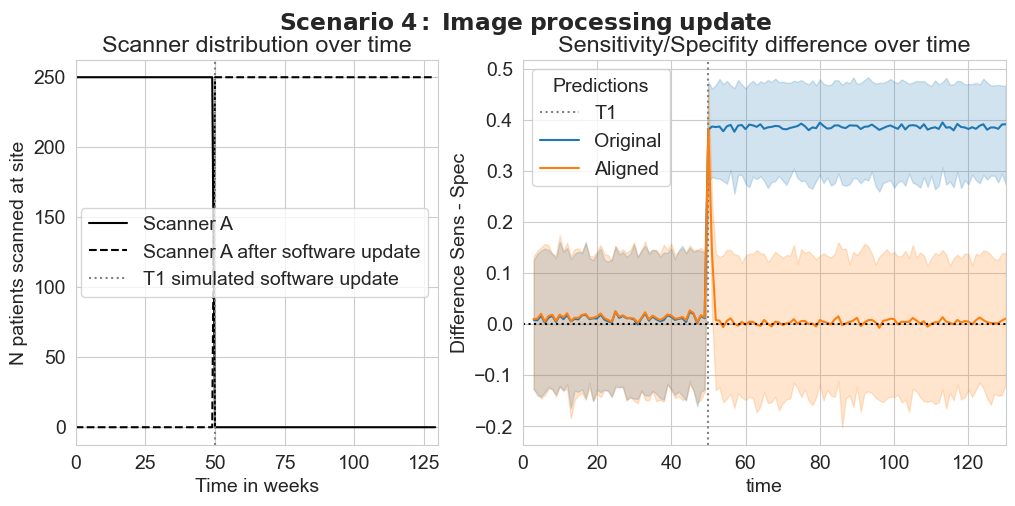

In [10]:
scanner_2_df = pd.read_csv(model_dir / "A_after_update.csv")

get_experiment_result_as_plot_update(
    scanner_1_df, scanner_2_df, reference_df, reference_threshold, n_repeat=250
)

## Sensitivity analyses

### Effect of adaptation set size

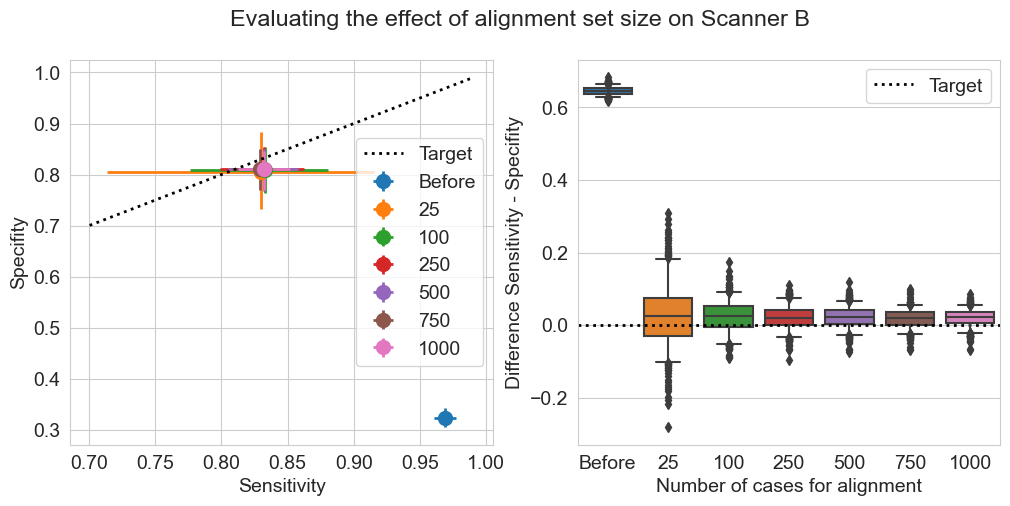

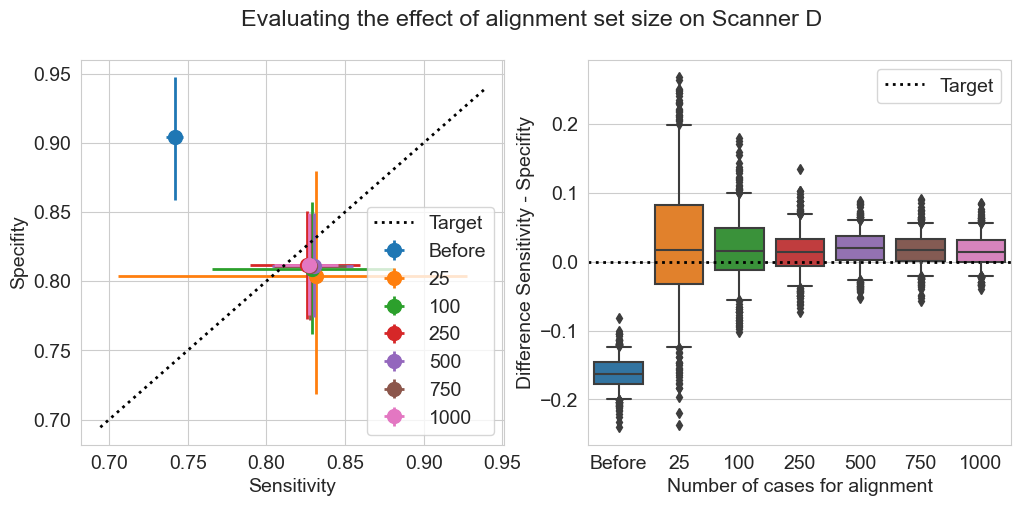

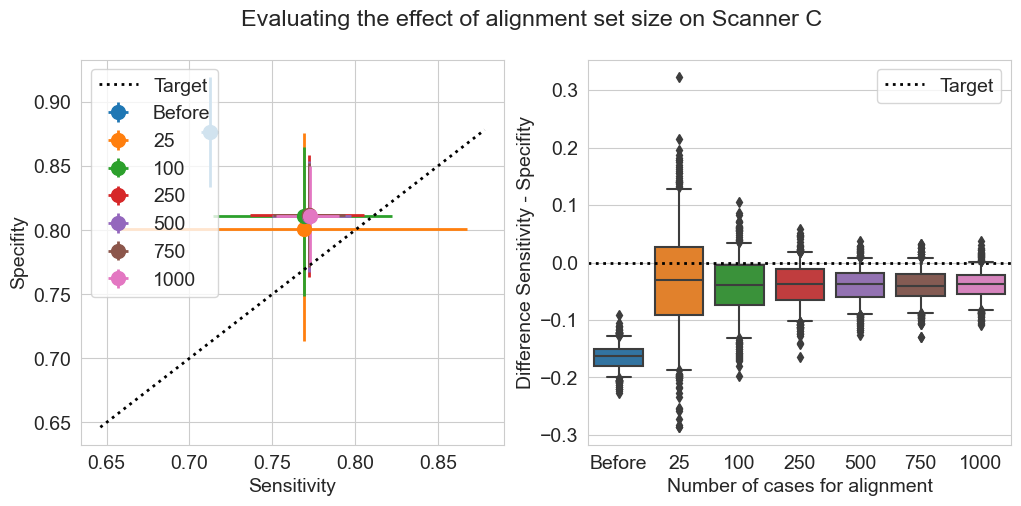

In [11]:
operating_point = "diag"
reference_df = all_dfs["A"]
reference_thres = get_op_threshold(
    reference_df.malignant, reference_df.pred1, operating_point
)[0]
n_repeat = 500
sizes = [25, 100, 250, 500, 750, 1000]
for dataset in datasets_to_evaluate:
    all_results_df = []
    all_results_df_auto = []
    df = all_dfs[dataset]
    for s in range(len(sizes)):
        results = evaluate_alignement_with_repeated_sampling(
            df,
            reference_df,
            reference_thres,
            n_repeat=n_repeat,
            alignment_size=sizes[s],
        )
        if s > 0:
            results = results.loc[results["Predictions"] == "Aligned"]
        all_results_df.append(results)
    all_results = pd.concat(all_results_df, ignore_index=True)
    all_results.rename(
        columns={"N_patients_alignment": "Number of cases for alignment"}, inplace=True
    )
    plot_results_ablation_studies(
        all_results, "Number of cases for alignment", dataset, file_name_prefix="exp2"
    )
    plt.show()

### Effect of reference set size

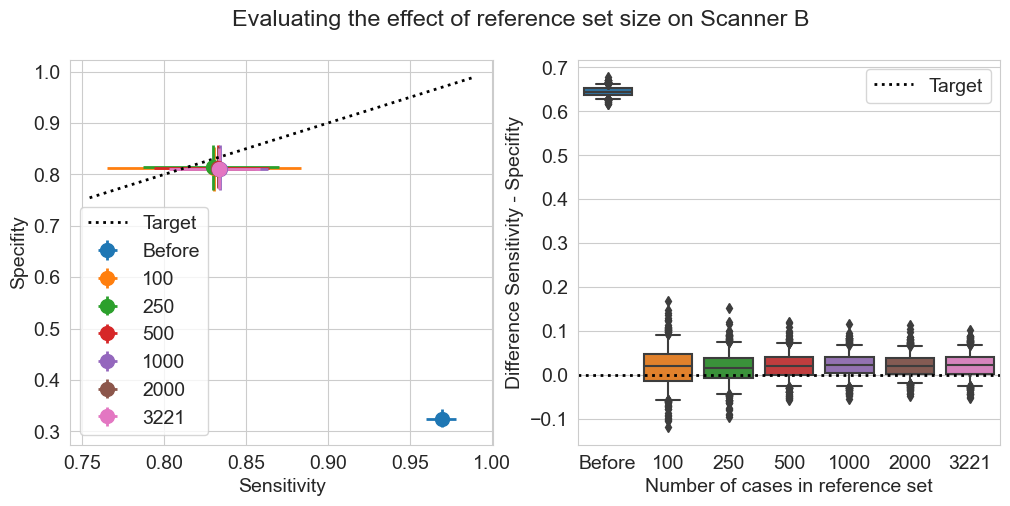

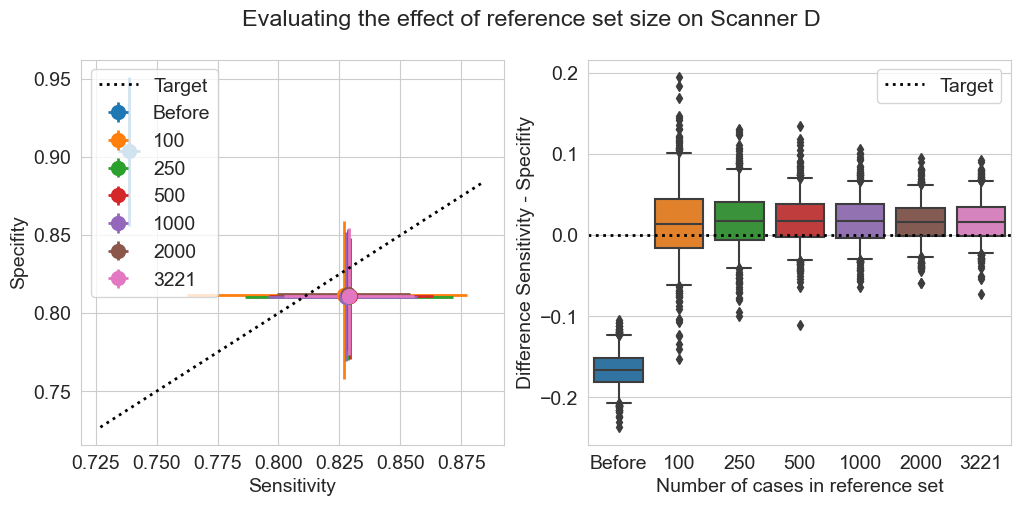

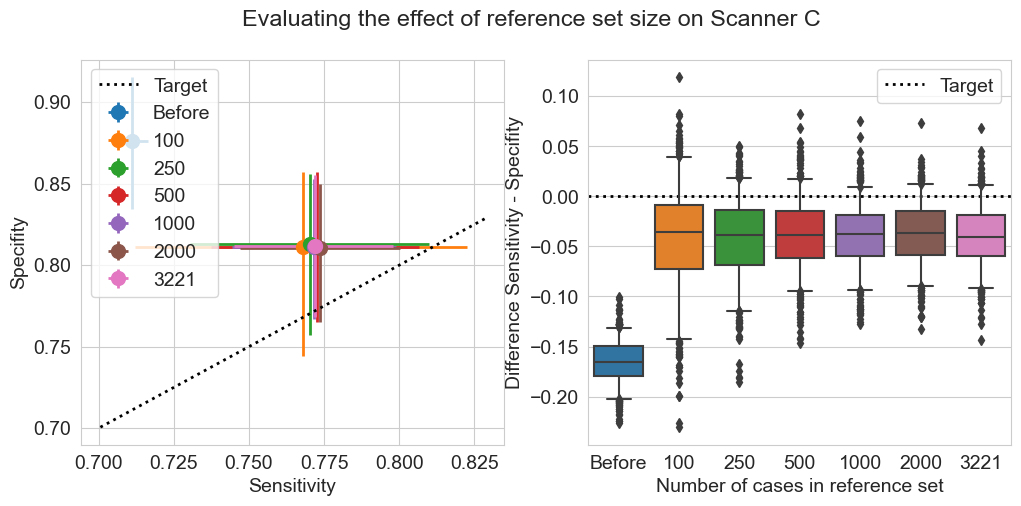

In [12]:
n_repeat = 500
sizes = [100, 250, 500, 1000, 2000, 3221]

for dataset in datasets_to_evaluate:
    all_results_df = []
    df = all_dfs[dataset]
    for s in range(len(sizes)):
        results = evaluate_alignement_with_repeated_sampling(
            df,
            reference_df,
            reference_thres,
            n_repeat=n_repeat,
            alignment_size=500,
            reference_size=sizes[s],
        )
        if s > 0:
            results = results.loc[results["Predictions"] == "Aligned"]
        all_results_df.append(results)
    all_results = pd.concat(all_results_df, ignore_index=True)
    all_results.rename(
        columns={"N_patients_reference": "Number of cases in reference set"},
        inplace=True,
    )
    plot_results_ablation_studies(
        all_results,
        "Number of cases in reference set",
        dataset,
        file_name_prefix="exp2b",
    )
    plt.show()

## Additional experiments

### Scenario 1 at other operating point, spec = 90

B


roc_auc          sens          spec         \
               mean    std   mean    std   mean    std   
Predictions                                              
Aligned       0.905  0.011  0.757  0.025  0.895  0.007   
Original      0.905  0.011  0.915  0.015  0.678  0.004   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                 -0.138  0.028  0.652  0.023  
Original                                 0.237  0.016  0.593  0.016

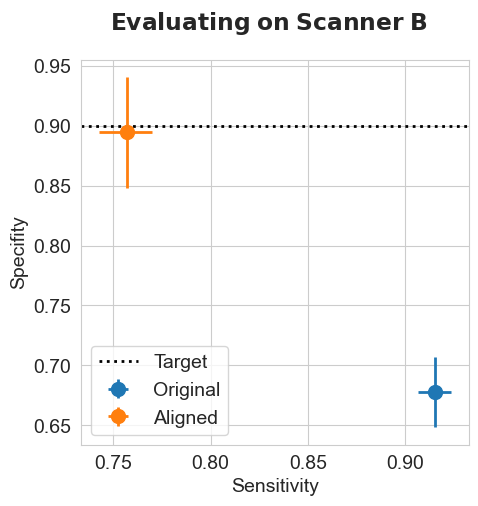

D


roc_auc          sens          spec         \
               mean    std   mean    std   mean    std   
Predictions                                              
Aligned       0.904  0.009  0.758  0.025  0.894  0.008   
Original      0.904  0.009  0.668  0.024  0.945  0.002   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                 -0.136  0.030  0.652  0.022  
Original                                -0.278  0.024  0.613  0.024

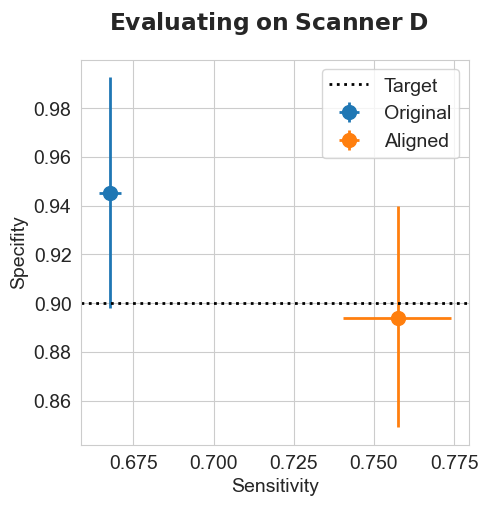

C


roc_auc         sens          spec         \
               mean   std   mean    std   mean    std   
Predictions                                             
Aligned       0.867  0.01  0.695  0.023  0.894  0.008   
Original      0.867  0.01  0.660  0.024  0.931  0.002   

            Difference Sensitivity - Specifity        youden         
                                          mean    std   mean    std  
Predictions                                                          
Aligned                                 -0.198  0.027  0.589  0.022  
Original                                -0.271  0.024  0.591  0.024

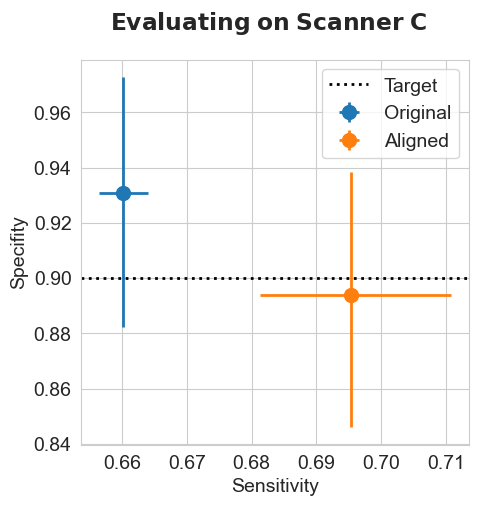

In [13]:
operating_point = "spec90"
reference_df = all_dfs["A"]
reference_thres = get_op_threshold(
    reference_df.malignant, reference_df.pred1, operating_point
)[0]

for dataset in datasets_to_evaluate:
    df = all_dfs[dataset]
    results = evaluate_alignement_with_repeated_sampling(
        df, reference_df, reference_thres, n_repeat
    )
    print(dataset.upper())
    display(
        results.groupby("Predictions")[
            ["roc_auc", "sens", "spec", "Difference Sensitivity - Specifity", "youden"]
        ].aggregate(["mean", "std"])
    )
    plot_results_ablation_studies(
        results,
        "Predictions",
        dataset,
        operating_point=operating_point,
        file_name_prefix="exp1spec90",
    )